In [1]:
import torch

/home/rd654/.cache/pypoetry/virtualenvs/pos-merge-Cf-JYAyy-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

In [ ]:
import sys
sys.path.append('../')

In [3]:
from src.utils.data import DatasetPreprocessor

In [4]:
from src.utils.data import POSLookup

In [5]:
from src.tokenizer import load_tokenizer

In [6]:
# setting up hydra config 
from hydra import compose, initialize
from omegaconf import OmegaConf
from src.config import BabyLMConfig 

from hydra.core.config_store import ConfigStore

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config", overrides=[
        "experiment.group=dev", "experiment.name=test-1", "experiment.dry_run=True", "objective_curriculum=base_pos_merge",
        "dataset.subconfig=strict_small_gold",
        "pos_lookup.similarity_metric=kl_divergence",
        ])


In [7]:
dataset = load_dataset(
    cfg.dataset.name,
    cfg.dataset.subconfig, 
)

**Loading in the tokenizer and creating a mapping of token_id to token_str**

In [8]:
tokenizer = load_tokenizer(cfg)

In [9]:
vocab_tokenizer = tokenizer._tokenizer.get_vocab()
vocab_tokenizer__key_to_token = {v: k for k, v in vocab_tokenizer.items()}

**Setting up the train dataset and the POS Lookup matrix**

In [10]:
data_preprocessor = DatasetPreprocessor(cfg, tokenizer)

train_dataset = dataset["train"].map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset["train"].column_names,
)


In [11]:
pos_lookup = POSLookup(train_dataset, tokenizer, similarity_metric=cfg.pos_lookup.similarity_metric)

100%|██████████| 8100/8100 [00:00<00:00, 27035.20it/s]


Getting the sum across the 1st dimension in order to compute the total count of POS tags (total occurences of that subword).

In [12]:
lookup_matrix = pos_lookup.lookup_matrix
total_freq = lookup_matrix.sum(dim=1)

**Sorting indices by their frequencies and plotting**

In [13]:
sorted_pos_freq_indices = torch.argsort(total_freq, descending=True)

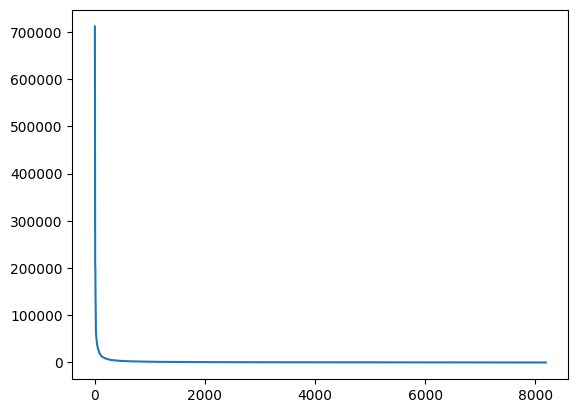

In [14]:
import matplotlib.pyplot as plt

plt.plot(total_freq[sorted_pos_freq_indices].numpy())

In [15]:
most_popular_tokens = sorted_pos_freq_indices[:5]
least_popular_tokens = sorted_pos_freq_indices[-5:]

print("POPULAR TOKENS")
print(10*"--")
for i in most_popular_tokens:
    print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
    print("Frequency: ", total_freq[i].item())

print(10*"--")
print("LEAST POPULAR TOKENS")
print(10*"--")
for i in least_popular_tokens:
    print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
    print("Frequency: ", total_freq[i].item())
print(10*"--")

# NOTE: We might also want to look at the distribution of POS tags in the dataset
# i.e. how to adjectives cluster, how do verbs cluster, etc.

POPULAR TOKENS
--------------------
18 --- ['.']
Frequency:  711862.0
16 --- [',']
Frequency:  554378.0
266 --- ['Ġthe']
Frequency:  469473.0
294 --- ['Ġand']
Frequency:  230639.0
284 --- ['Ġto']
Frequency:  223318.0
--------------------
LEAST POPULAR TOKENS
--------------------
193 --- ['Ā']
Frequency:  0.0
194 --- ['ā']
Frequency:  0.0
195 --- ['Ă']
Frequency:  0.0
196 --- ['ă']
Frequency:  0.0
197 --- ['Ą']
Frequency:  0.0
--------------------


#### Plotting similarity among most and least popular tokens

In [17]:
similarity_vals_popular = pos_lookup.find_similar(most_popular_tokens)
similarity_vals_least_popular = pos_lookup.find_similar(least_popular_tokens)

In [18]:
def plot_vals(similarity_vals):
    for i, val in enumerate(similarity_vals):

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        plt.plot(similarity_vals_sorted)#, label=f"POS {val}")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


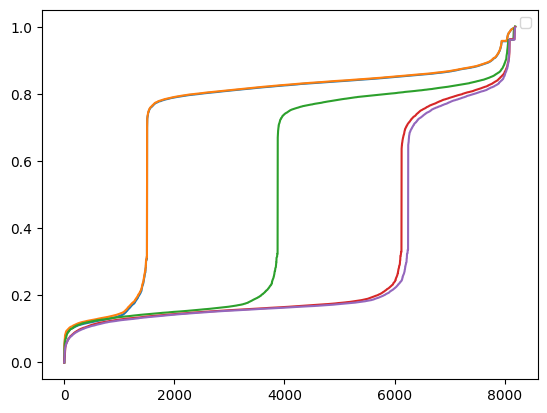

In [19]:
plot_vals(similarity_vals_popular)


In [20]:
similarity_vals_least_popular.shape

torch.Size([5, 8192])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


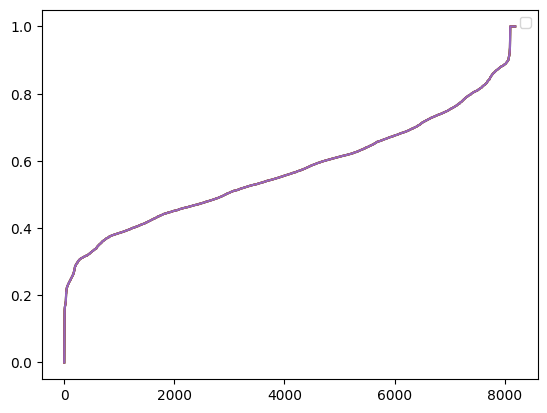

In [21]:
plot_vals(similarity_vals_least_popular)

### Grouping by type of POS TAG 

In [22]:
from src.utils.data import POS_TAG_MAP

In [23]:
normalized_lookup_matrix = lookup_matrix + 1e-8 
normalized_lookup_matrix = normalized_lookup_matrix / normalized_lookup_matrix.sum(dim=1).unsqueeze(1)

In [24]:
def get_representative_token_idx_for_pos(pos_tag, comparison_factor=0.7):
    """
    returns a tuple of 
        * the indices of tokens that are primarily of a given POS tag, as well as 
        * the same indices but sorted by their frequency (descending)
    """
    primarily_pos_mask = normalized_lookup_matrix[:, POS_TAG_MAP[pos_tag]] > comparison_factor
    primarily_pos_idx = primarily_pos_mask.nonzero(as_tuple=True)[0]

    primarily_pos_idx_sorted_indices = torch.argsort(total_freq[primarily_pos_idx], descending=True)
    primarily_pos_idx_sorted = primarily_pos_idx[primarily_pos_idx_sorted_indices]

    return primarily_pos_idx, primarily_pos_idx_sorted

In [25]:
def print_top_representative_tokens(primarily_pos_idx_sorted):
    for i in primarily_pos_idx_sorted[:5]:
        print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
        print("Frequency: ", total_freq[i].item())
        print("POS Distribution: ", normalized_lookup_matrix[i].numpy())
        print(10*"--")

In [26]:
def print_least_representative_tokens(primarily_pos_idx_sorted):
    for i in primarily_pos_idx_sorted[-5:]:
        print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
        print("Frequency: ", total_freq[i].item())
        print("POS Distribution: ", normalized_lookup_matrix[i].numpy())
        print(10*"--")

In [27]:
representative_POS_tokens = { 
    tag: get_representative_token_idx_for_pos(tag) for tag in POS_TAG_MAP.keys() if tag not in ["X", "ADV"]
}

In [30]:
print("MOST REPRESENTATIVE TOKENS")
print(10*"--")
for tag in representative_POS_tokens.keys():
    print(tag)
    print(10*"--")
    print_top_representative_tokens(representative_POS_tokens[tag][1])
    print(10*"--")

MOST REPRESENTATIVE TOKENS
--------------------
NOUN
--------------------
87 --- ['s']
Frequency:  51957.0
POS Distribution:  [7.42229164e-01 1.42252252e-01 5.00413813e-02 1.02007426e-02
 6.48613274e-03 3.79159697e-03 5.73551189e-03 2.19027270e-02
 6.35140575e-04 4.23427060e-04 1.44542605e-02 1.84768171e-03]
--------------------
274 --- ['er']
Frequency:  18788.0
POS Distribution:  [0.7768256  0.05892059 0.1007558  0.01527571 0.00244837 0.00244837
 0.00532255 0.02459016 0.00095806 0.00079838 0.00888865 0.00276772]
--------------------
6 --- ['"']
Frequency:  18699.0
POS Distribution:  [0.719985   0.11005936 0.05765014 0.00636398 0.00165784 0.02422589
 0.00754051 0.04449436 0.0010161  0.0010161  0.01893149 0.0070592 ]
--------------------
567 --- ['Ġtime']
Frequency:  16658.0
POS Distribution:  [9.6986431e-01 3.8419978e-03 3.5418419e-03 6.6034339e-04 1.4407492e-03
 1.5007805e-03 1.6208428e-03 8.2242768e-03 6.0031217e-13 3.6018729e-04
 8.8846199e-03 6.0031216e-05]
--------------------
59

In [32]:
print("LEAST REPRESENTATIVE TOKENS")
print(10*"--")
for tag in representative_POS_tokens.keys():
    print(tag)
    print(10*"--")
    print_least_representative_tokens(representative_POS_tokens[tag][1])
    print(10*"--")

LEAST REPRESENTATIVE TOKENS
--------------------
NOUN
--------------------
1692 --- ['Ġdaught']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
5920 --- ['iggler']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
6498 --- ['celer']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
5721 --- ['Ġembarr']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
5806 --- ['Ġmassachus']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
--------------------
VERB
--------------------
1915 --- ['Ġcharac']
Frequency:  7.0
POS Distribution:  [2

We now plot for each of the most popular tokens that are representative of each POS tag how those representative tokens distribute their similarity to other tokens

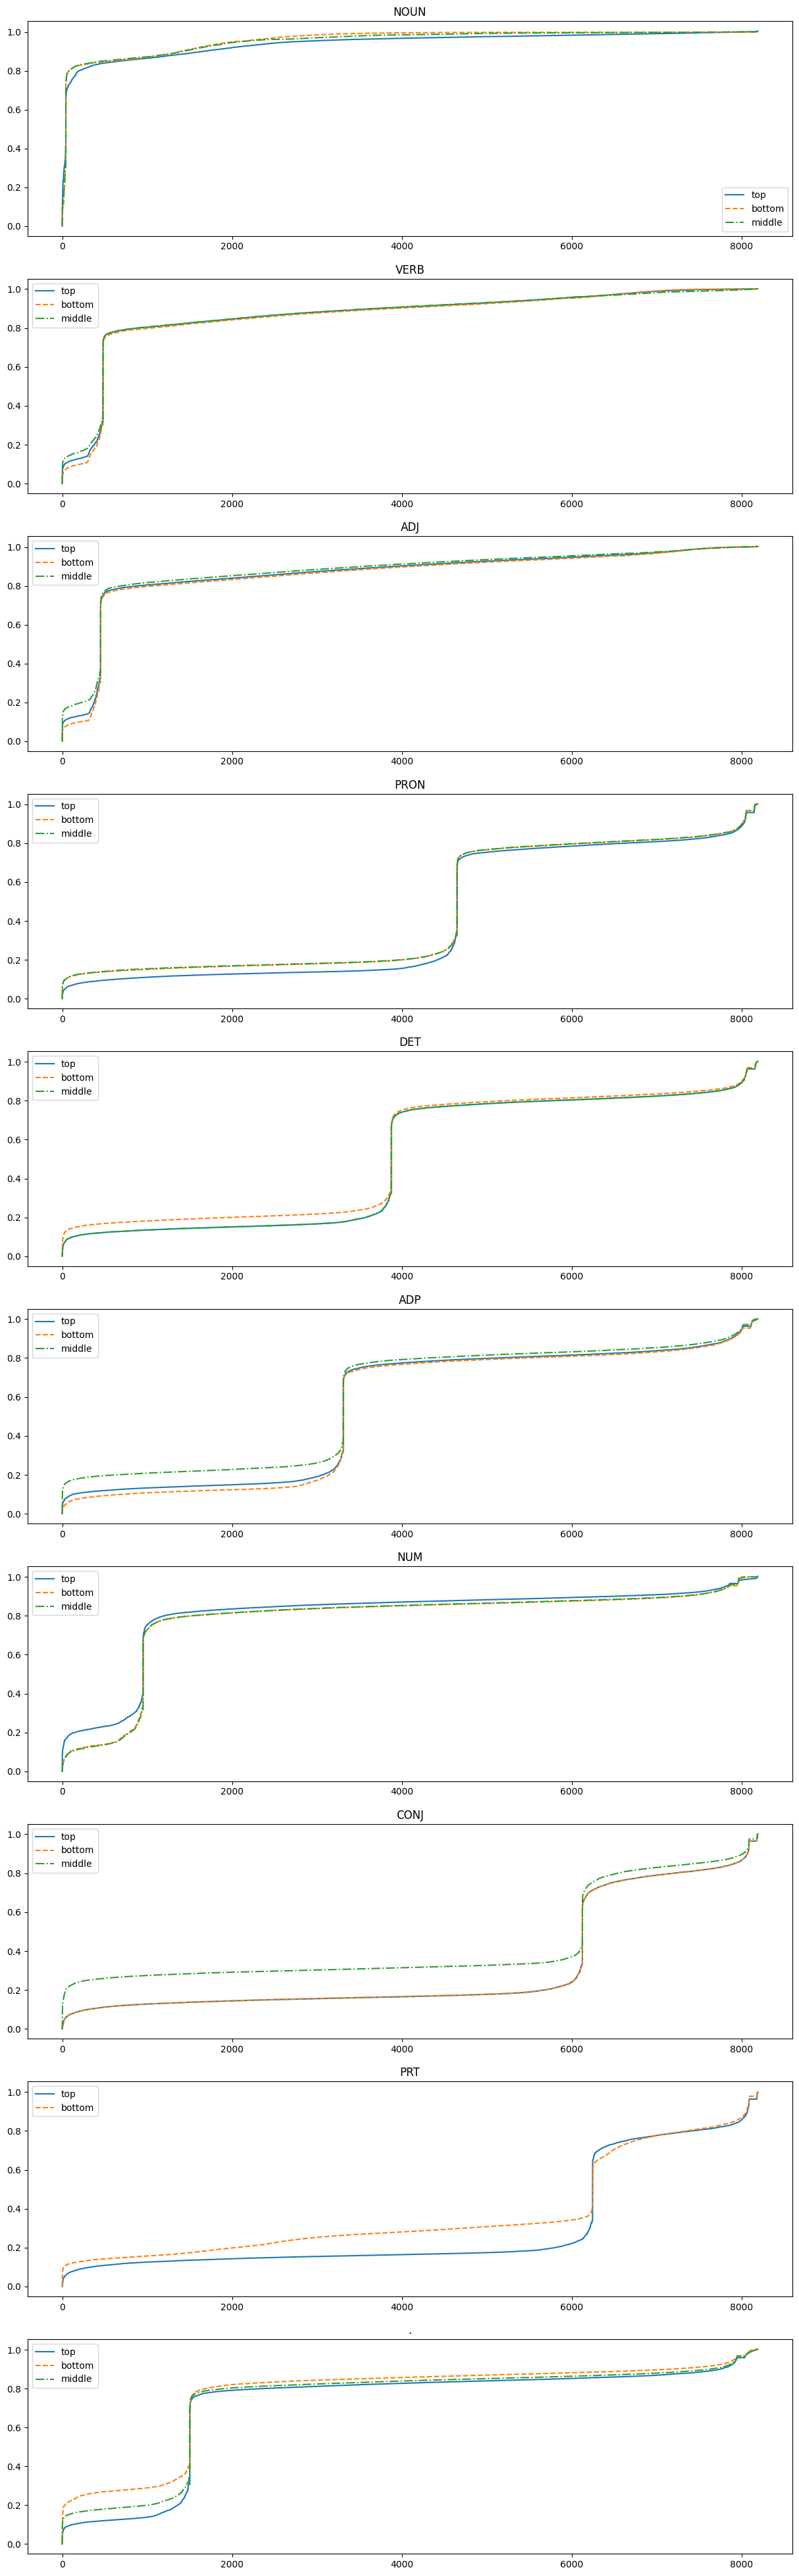

In [33]:
fig, axs = plt.subplots(len(representative_POS_tokens), 1, figsize=(15, 50))

num_from_each = 1

for plot_idx, (tag, (tag_idx, tag_idx_sorted)) in enumerate(representative_POS_tokens.items()):

    if num_from_each*2 >= len(tag_idx_sorted):
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted))
        ])
    else:
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted)),
            torch.randint(num_from_each, len(tag_idx_sorted)-num_from_each, (num_from_each,))
        ])

    pos_reprs = tag_idx_sorted[sample_idx]
    pos_reprs_sim_dist = pos_lookup.find_similar(pos_reprs)
    
    for i, val in enumerate(pos_reprs_sim_dist):

        # For the first num_from_each (top) make like solid, for the next num_from_each (bottom) make like dashed, for the rest dotted
        line_style = "-" if i < num_from_each else "--" if i < num_from_each*2 else "-."
        label = "top" if i < num_from_each else "bottom" if i < num_from_each*2 else "middle"

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        axs[plot_idx].plot(similarity_vals_sorted, linestyle=line_style, label=label)

    axs[plot_idx].set_title(tag)
    axs.flat[plot_idx].legend()

plt.legend()
plt.show()


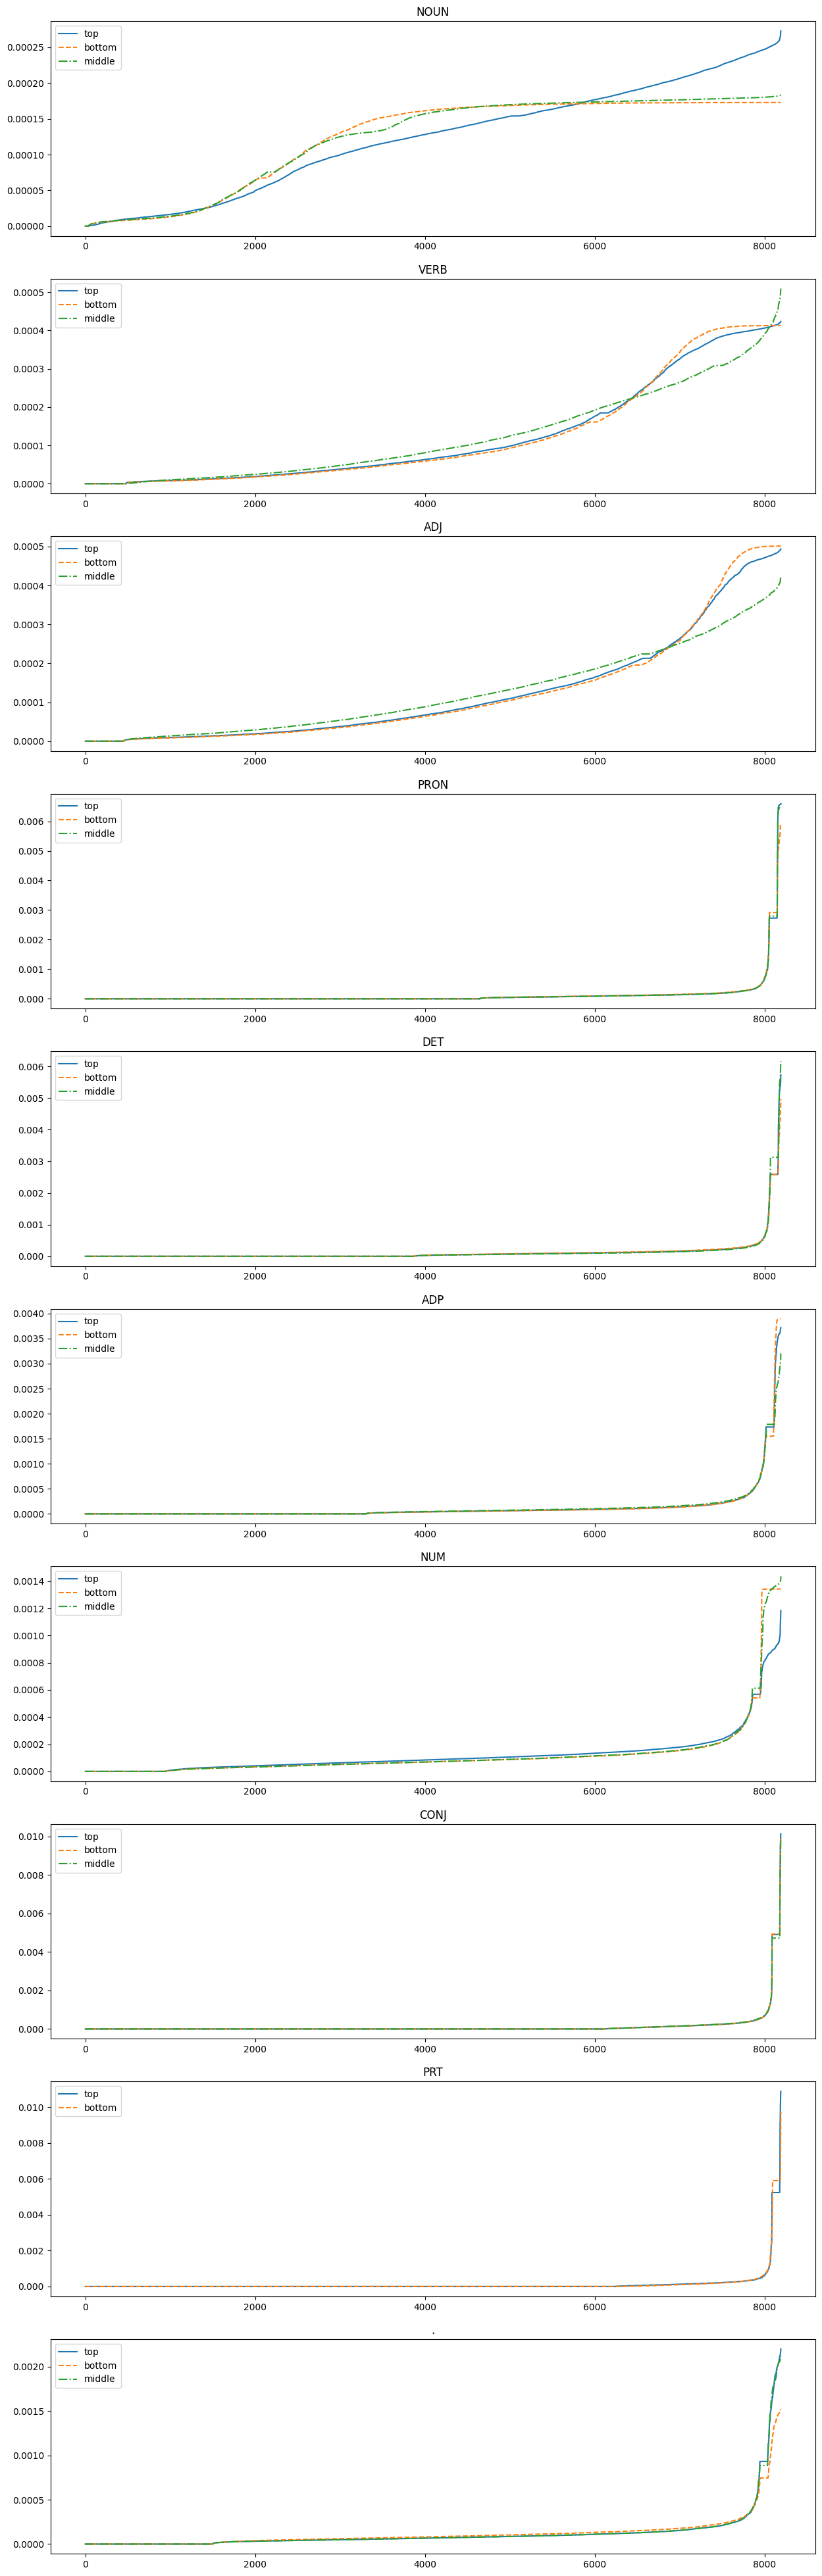

In [35]:
temp_parameter = 0.05

fig, axs = plt.subplots(len(representative_POS_tokens), 1, figsize=(15, 50))

num_from_each = 1

for plot_idx, (tag, (tag_idx, tag_idx_sorted)) in enumerate(representative_POS_tokens.items()):

    if num_from_each*2 >= len(tag_idx_sorted):
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted))
        ])
    else:
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted)),
            torch.randint(num_from_each, len(tag_idx_sorted)-num_from_each, (num_from_each,))
        ])

    pos_reprs = tag_idx_sorted[sample_idx]
    pos_reprs_sim_dist = pos_lookup.find_similar(pos_reprs)

    # apply the temperature parameter
    pos_reprs_sim_dist = torch.exp(pos_reprs_sim_dist / temp_parameter)
    pos_reprs_sim_dist = pos_reprs_sim_dist / pos_reprs_sim_dist.sum(dim=1).unsqueeze(1)
    
    for i, val in enumerate(pos_reprs_sim_dist):

        # For the first num_from_each (top) make like solid, for the next num_from_each (bottom) make like dashed, for the rest dotted
        line_style = "-" if i < num_from_each else "--" if i < num_from_each*2 else "-."
        label = "top" if i < num_from_each else "bottom" if i < num_from_each*2 else "middle"

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        axs[plot_idx].plot(similarity_vals_sorted, linestyle=line_style, label=label)

    axs[plot_idx].set_title(tag)
    axs.flat[plot_idx].legend()

plt.legend()
plt.show()
